# KANADA-MNIST numbers generation with Autoencoder
In this notebook, I am going to create a simple autoencoder, which will learn to generate KANADA-MNIST numbers. I am going to do it by using existing KANADA-MNIST numbers images to train my autoencoder to encode the existing numbers into two-dimensional space and afterwards decode back into the image. By learning this the decoder part of my network should learn how to generate a random KANADA-MNIST number from two random numbers.

In [1]:
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model
from keras.datasets import mnist, cifar100,cifar10
import numpy as np
import json
import os
import pickle
import matplotlib.pyplot as plt
import pandas as pd

Using TensorFlow backend.
/home/zeldax/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/zeldax/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/zeldax/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/zeldax/.local/lib/python3.6/site-packages/tensorflow/python

# Prepare Data

In [2]:
x_train = pd.read_csv("train.csv")
y_train = x_train['label']
del x_train['label']
# reshape to 28,28 for convolution and add extra dimension indicating the channel.
x_train = x_train.to_numpy().reshape(len(x_train),28, 28).astype('float32') / 255.
x_train =x_train.reshape(x_train.shape +(1,))
x_train.shape

(60000, 28, 28, 1)

# Encoder


In [3]:
encoder_input = Input(shape=(28,28,1), name='encoder_input')

In [4]:
x = Conv2D(filters = 32,kernel_size = 3
           ,strides = 1,padding = 'same', name = 'encoder_conv_1')(encoder_input)
x = LeakyReLU()(x)

In [5]:
x = Conv2D(filters = 64,kernel_size = 3
           ,strides = 2,padding = 'same', name = 'encoder_conv_2')(x)
x = LeakyReLU()(x)

In [6]:
x = Conv2D(filters = 64,kernel_size = 3
           ,strides = 2,padding = 'same', name = 'encoder_conv_3')(x)
x = LeakyReLU()(x)

In [7]:
x = Conv2D(filters = 64,kernel_size = 3
           ,strides = 1,padding = 'same', name = 'encoder_conv_4')(x)
x = LeakyReLU()(x)

In [8]:
# we need this to know the shape for decoder image recreation
shape_before_flattening = K.int_shape(x)[1:]
shape_before_flattening

(7, 7, 64)

In [9]:
x = Flatten()(x)

In [10]:
encoder_output= Dense(2, name='encoder_output')(x)

In [11]:
encoder = Model(encoder_input, encoder_output)
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
encoder_conv_3 (Conv2D)      (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 64)          0   

# Decoder

In [12]:
decoder_input = Input(shape=(2,), name='decoder_input')

In [13]:
x = Dense(np.prod(shape_before_flattening))(decoder_input) 
x = Reshape(shape_before_flattening)(x)

In [14]:
x = Conv2DTranspose(filters = 64,kernel_size = 3
           ,strides = 1,padding = 'same', name = 'decoder_conv_t_1')(x)
x = LeakyReLU()(x)

In [15]:
x = Conv2DTranspose(filters = 64,kernel_size = 3
           ,strides = 2,padding = 'same', name = 'decoder_conv_t_2')(x)
x = LeakyReLU()(x)

In [16]:
x = Conv2DTranspose(filters = 32,kernel_size = 3
           ,strides = 2,padding = 'same', name = 'decoder_conv_t_3')(x)
x = LeakyReLU()(x)

In [17]:
x = Conv2DTranspose(filters = 1,kernel_size = 3
           ,strides = 1,padding = 'same', name = 'decoder_conv_t_4')(x)
x = Activation('sigmoid')(x)

In [18]:
decoder_output = x
decoder = Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t_1 (Conv2DTran (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t_2 (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 64)        0   

# Autoencoder

In [19]:
# Connect encoder and decoder into one model.
model_input = encoder_input # 
model_output = decoder(encoder_output) # 

model = Model(model_input, model_output)

In [20]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
encoder_conv_3 (Conv2D)      (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 64)          0   

# Training Autoencoder

In [21]:
optimizer = Adam(lr=0.01)

In [22]:
model.compile(optimizer=optimizer, loss='binary_crossentropy')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [23]:
model.fit(
    x = x_train
    , y = x_train
    , batch_size = 128
    , shuffle = True
    , epochs = 5
)


Epoch 1/5
60000/60000 [==============================] - 28s 462us/step - loss: 0.1946
Epoch 2/5
60000/60000 [==============================] - 28s 464us/step - loss: 0.1623
Epoch 3/5
60000/60000 [==============================] - 28s 462us/step - loss: 0.1578
Epoch 4/5
60000/60000 [==============================] - 28s 461us/step - loss: 0.1555
Epoch 5/5
60000/60000 [==============================] - 28s 465us/step - loss: 0.1544


In [25]:
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy')
model.fit(
    x = x_train
    , y = x_train
    , batch_size = 128
    , shuffle = True
    , epochs = 5
)

Epoch 1/5
60000/60000 [==============================] - 28s 464us/step - loss: 0.1489
Epoch 2/5
60000/60000 [==============================] - 28s 462us/step - loss: 0.1476
Epoch 3/5
60000/60000 [==============================] - 28s 463us/step - loss: 0.1469
Epoch 4/5
60000/60000 [==============================] - 28s 464us/step - loss: 0.1463
Epoch 5/5
60000/60000 [==============================] - 28s 467us/step - loss: 0.1459


# Visualisation
Lets plot our predictions. From the image we can see that most of the data under the same label is close to each other.

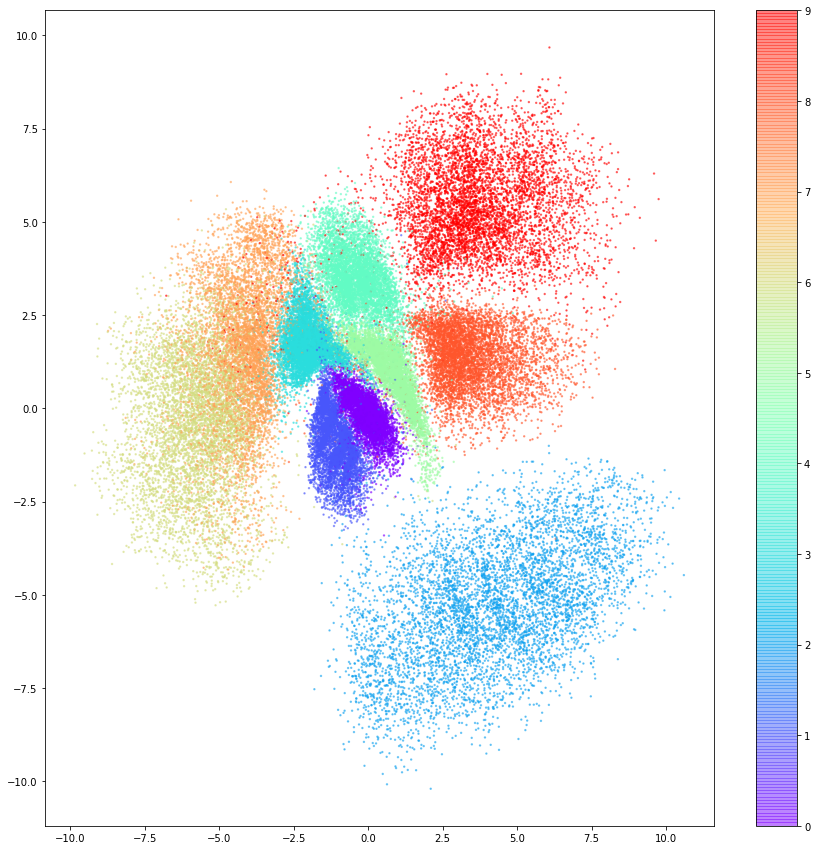

In [33]:
example_images = x_train[:]
example_labels = y_train[:]

z_points = encoder.predict(example_images)

plt.figure(figsize=(15, 15))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= y_train[:]
            , alpha=0.5, s=2)
plt.colorbar()
plt.show()

By encoding the images and generating the predictions with encoder, we can visually inspect how good is our model on seen data

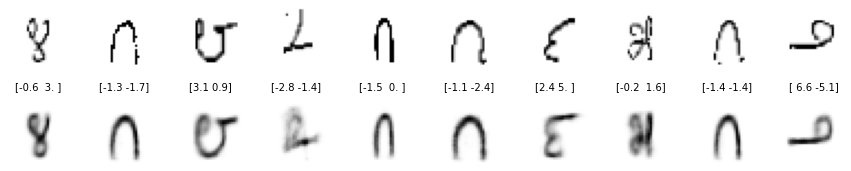

In [34]:
n_to_show = 10
example_idx = np.random.choice(range(len(x_train)), n_to_show)
example_images = x_train[example_idx]

z_points_example = encoder.predict(example_images)

reconst_images = decoder.predict(z_points_example)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_points_example[i],1)), fontsize=10, ha='center', transform=ax.transAxes)   
    ax.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')

Now lets try to generate some random numbers and use it for our prediction.
From the geneated images we can see that some of the generated number are very similar to before shown examples and some are hardly identifiable.

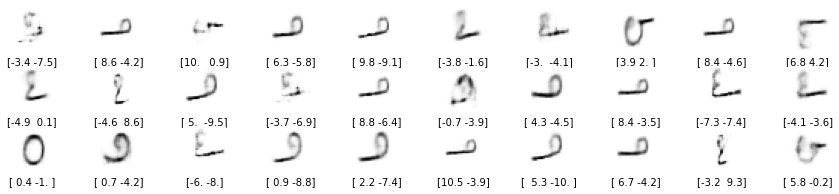

In [35]:
collumns = 10
rows = 3

x = np.random.uniform(min(z_points[:, 0]), max(z_points[:, 0]), size = collumns * rows)
y = np.random.uniform(min(z_points[:, 1]), max(z_points[:, 1]), size = collumns * rows)
random_encoded_img = np.array(list(zip(x, y)))
reconst = decoder.predict(random_encoded_img)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)


for i in range(collumns*rows):
    ax = fig.add_subplot(rows, collumns, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(random_encoded_img[i],1)),
            fontsize=10, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

if we plot our generated image points alongside the points used for training we can see why.
The geneared point, which are close to clusters will also be very similar to the generated numbers, but the geneated points which are outliners to any of the clusters are not really similar to any of the particular number group

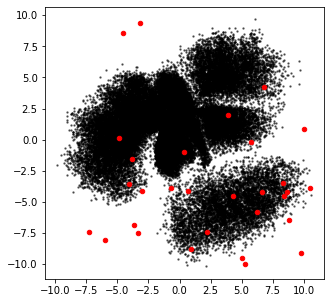

In [36]:
plt.figure(figsize=(5, 5))
#points of the original images
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)

#our generated points marked as red
plt.scatter(random_encoded_img[:, 0] , random_encoded_img[:, 1], c = 'red', alpha=1, s=20)
plt.show()

We can visualise this better by dividing our prediction plot into small sub areas  and generating the image by using the point from each area

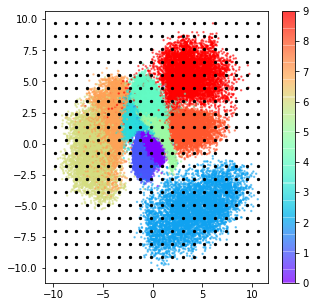

In [38]:
plt.figure(figsize=(5, 5))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= y_train[:]
            , alpha=0.5, s=2)
plt.colorbar()

x = np.linspace(min(z_points[:, 0]), max(z_points[:, 0]), 20)
y = np.linspace(max(z_points[:, 1]), min(z_points[:, 1]), 20)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)))

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'black'#, cmap='rainbow' , c= example_labels
            , alpha=1, s=5)
plt.show()

As we can see prediction areas belonging to our data clusters gives us a good images and the predictions from areas with no data are hardly identifiable

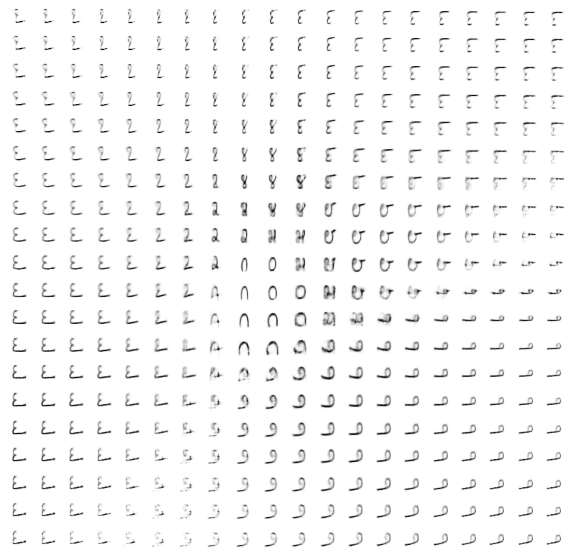

In [44]:
reconst = decoder.predict(z_grid)
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(20**2):
    ax = fig.add_subplot(20, 20, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')